# 🔍 Predicting Item Prices from Descriptions (Part 2)

# ⚔️ Part 2: Model Benchmarking

We’ll compare traditional ML models (SVR, LR, XGBoost) using vectorized text, against frontier LLMs like GPT-4o, Claude, LLaMA, and more —

📊 Which model predicts prices best? Let’s find out.

🧠 This notebook assumes you're familiar with NLP techniques (e.g., converting text to vectors using Bag-of-Words or Word2Vec) and traditional ML models (like SVR, Logistic Regression, XGBoost) along with basic evaluation metrics.

- ⚙️ Hardware: ✅ CPU is sufficient — no GPU required
- 🛠️ Requirements: 🔑 Open API Key, Anthropic API key, Groq API key

In [2]:
# !pip install xgboost

In [3]:
# imports

import os, importlib, re, csv, tiktoken, math
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.svm import LinearSVR
import xgboost as xgb
from dotenv import load_dotenv
from openai import OpenAI
from anthropic import Anthropic

# 📥 Load Preprocessed Dataset

In [13]:
HF_USER = "Lizk75"
DATASET_NAME = f"{HF_USER}/pricer-data"

dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

In [20]:
print(train[0]["text"])

How much does this cost to the nearest dollar?

Detail King TNT Tire Gel - Vibrant Car Tire Shine - Tire Dressing and Trim Shine - Gallon
The TNT Tire Gel is a water-based, silicone gel dressing that gives tires a bright, glossy finish. Easy to apply and durable, this gel is a remarkable product for both auto detailers and car enthusiasts looking to achieve a quick shine on their tires. For Best Results Apply to clean tires. Squeeze a few lines of product onto an Automotive Tire Dressing Applicator. Thoroughly rub into the grooves of your tires. Scrub both horizontally and vertically to reach all crevices. Allow the gel to set into the tires for a half hour before driving. This helps to avoid sling. You’re done! Just a little bit of gel and your tires look brand new

Price is $130.00


In [21]:
print(train[0]["price"])

129.95


# 🛠️ Prepare Data for models

In [15]:
def test_prompt(text: str) -> str:
    """
    Mimics .test_prompt() from custom class.
    Keeps 'Price is $' but removes the number after it.
    """
    return re.sub(r"(\n\nPrice is \$).*", r"\1", text)

In [16]:
# Extract prices
prices = np.array([float(datapoint["price"]) for datapoint in train])

# Extract cleaned prompts
documents = [test_prompt(datapoint["text"]) for datapoint in train]

# Set random seed for reproducibility
np.random.seed(42)

In [17]:
print(documents[0])

How much does this cost to the nearest dollar?

Detail King TNT Tire Gel - Vibrant Car Tire Shine - Tire Dressing and Trim Shine - Gallon
The TNT Tire Gel is a water-based, silicone gel dressing that gives tires a bright, glossy finish. Easy to apply and durable, this gel is a remarkable product for both auto detailers and car enthusiasts looking to achieve a quick shine on their tires. For Best Results Apply to clean tires. Squeeze a few lines of product onto an Automotive Tire Dressing Applicator. Thoroughly rub into the grooves of your tires. Scrub both horizontally and vertically to reach all crevices. Allow the gel to set into the tires for a half hour before driving. This helps to avoid sling. You’re done! Just a little bit of gel and your tires look brand new

Price is $


# 📊 Model Evaluation with testing.py

- Runs predictions and computes errors on test data
- Metrics: Absolute error, RMSLE, and hit rate
- Visual: Scatter plot of predicted vs. actual prices (color-coded)

In [22]:
import helpers.testing
importlib.reload(helpers.testing)

from helpers.testing import Tester

results = {}  # Store each model's tester to compare and find the best performer

# 🎯 Price Prediction with Traditional ML

## Bag-of-Words + Linear Regression

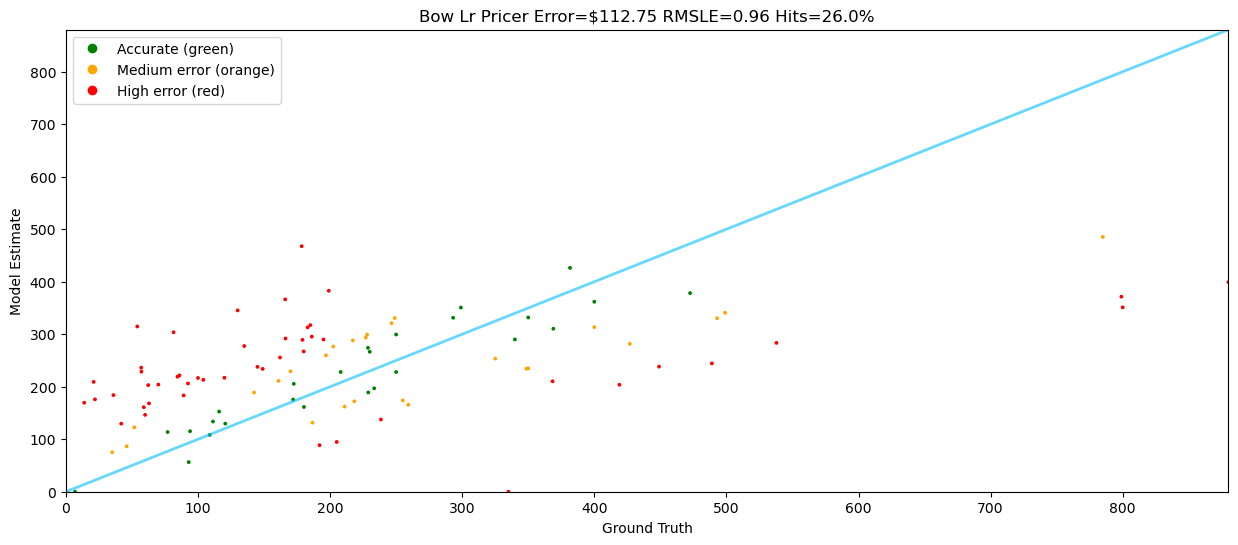

In [23]:
# Use the CountVectorizer for a Bag of Words model
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

def bow_lr_pricer(datapoint):
    x = vectorizer.transform([test_prompt(datapoint["text"])])
    return max(regressor.predict(x)[0], 0)

tester = Tester(bow_lr_pricer, test.select(range(100)))
tester.run()
results["Bag of Words LR"] = tester

## Word2Vec + Linear Regression

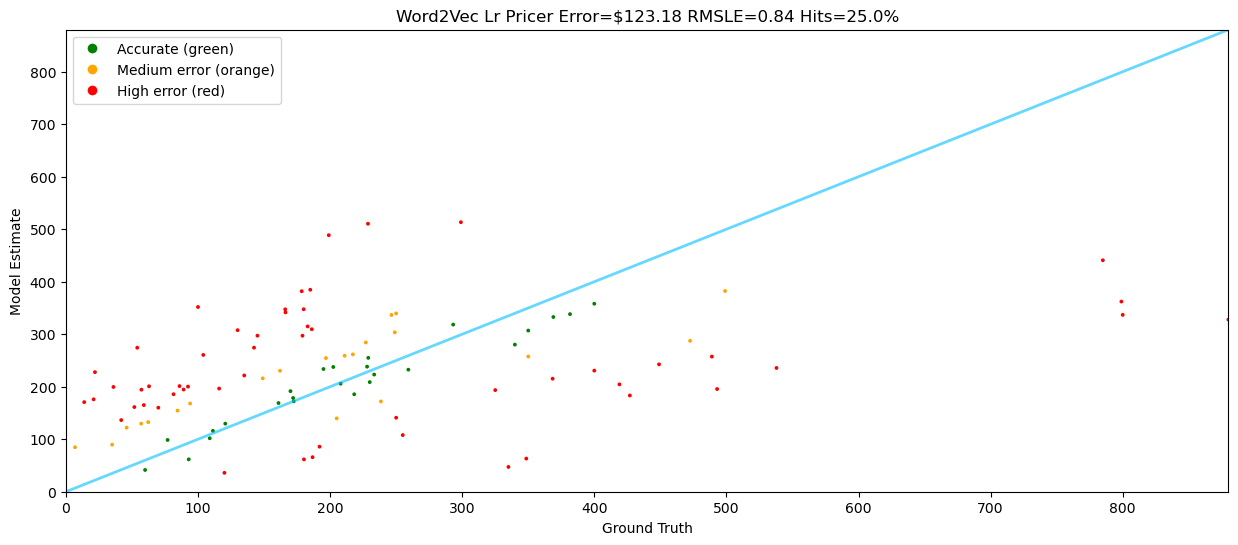

In [24]:
# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=4)

# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

def word2vec_lr_pricer(datapoint):
    doc = test_prompt(datapoint["text"])
    vec = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([vec])[0])

tester = Tester(word2vec_lr_pricer, test.select(range(100)))
tester.run()
results["Word2Vec LR"] = tester

## Word2Vec + Linear SVR

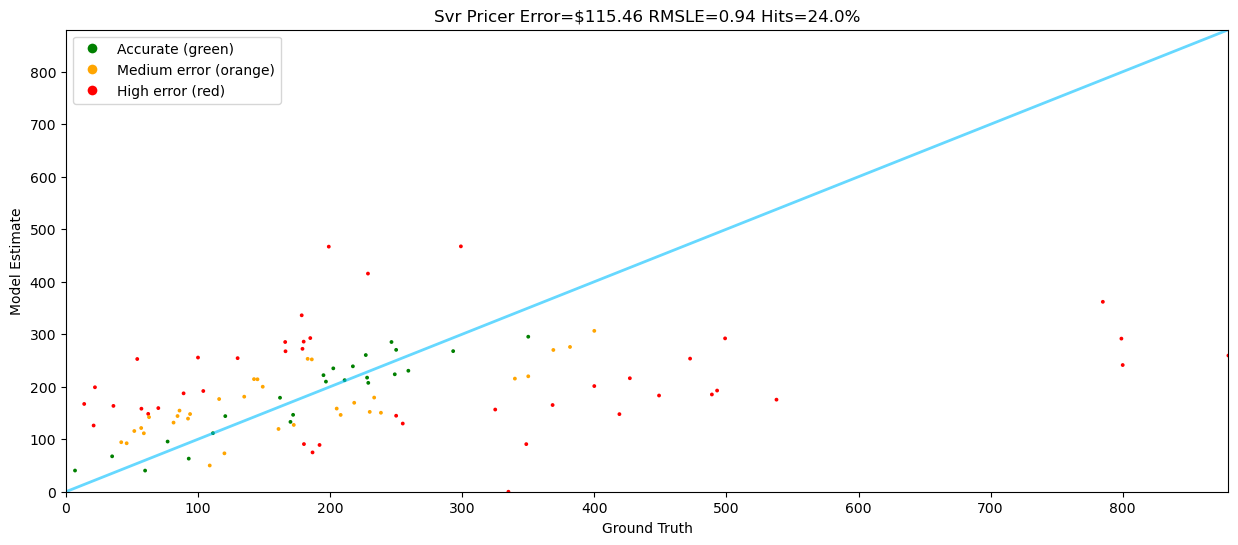

In [25]:
svr_regressor = LinearSVR()
svr_regressor.fit(X_w2v, prices)

def svr_pricer(datapoint):
    np.random.seed(42)
    doc = test_prompt(datapoint["text"])
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

tester = Tester(svr_pricer, test.select(range(100)))
tester.run()
results["Linear SVR"] = tester

## Word2Vec + XGBoost 

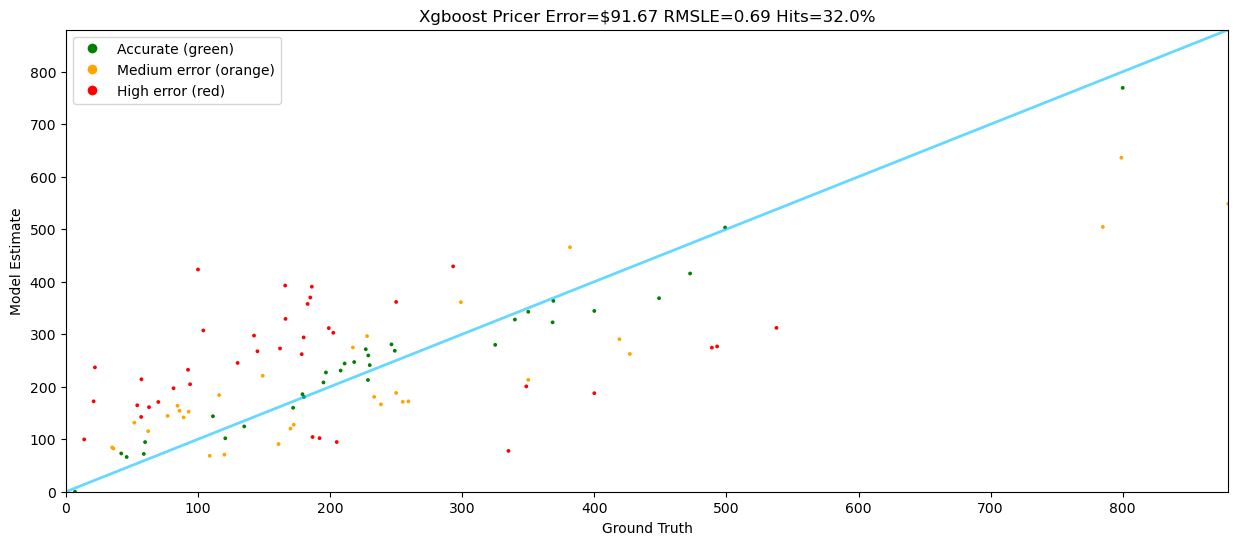

In [26]:
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)
xgb_model.fit(X_w2v, prices)

def xgboost_pricer(datapoint):
    doc = test_prompt(datapoint["text"])
    doc_vector = document_vector(doc)
    return max(0, xgb_model.predict([doc_vector])[0])

tester = Tester(xgboost_pricer, test.select(range(100)))
tester.run()
results["XGBoost Regressor"] = tester


I initially tried Random Forest, but it struggled with high training time and didn’t scale well with this data.
That’s why I opted for XGBoost — it’s faster, handles large datasets efficiently, and often delivers better performance on structured data.

# 🚀 Price Prediction with Frontier LLMs

In [48]:
load_dotenv(override=True)

# Get API keys from environment
openai_api_key = os.getenv('OPENAI_API_KEY')
if not openai_api_key: print("❌ OPENAI_API_KEY is missing")

anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')
if not anthropic_api_key: print("❌ ANTHROPIC_API_KEY is missing")

groq_api_key = os.getenv('GROQ_API_KEY')
if not groq_api_key: print("❌ GROQ_API_KEY is missing")


# Initialize clients
openai = OpenAI(api_key=openai_api_key)
claude = Anthropic(api_key=anthropic_api_key)
groq = OpenAI(api_key=groq_api_key, base_url="https://api.groq.com/openai/v1")

In [49]:
def messages_for(datapoint):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = test_prompt(datapoint["text"]).replace(" to the nearest dollar", "").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nDetail King TNT Tire Gel - Vibrant Car Tire Shine - Tire Dressing and Trim Shine - Gallon\nThe TNT Tire Gel is a water-based, silicone gel dressing that gives tires a bright, glossy finish. Easy to apply and durable, this gel is a remarkable product for both auto detailers and car enthusiasts looking to achieve a quick shine on their tires. For Best Results Apply to clean tires. Squeeze a few lines of product onto an Automotive Tire Dressing Applicator. Thoroughly rub into the grooves of your tires. Scrub both horizontally and vertically to reach all crevices. Allow the gel to set into the tires for a half hour before driving. This helps to avoid sling. You’re done! Just a little bit of gel and your tires look brand new'},
 {'role': 'assistant', 'content': 'Price is $'}]

In [50]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

get_price("The price is roughly $99.99 because blah blah") # Testing

99.99

In [51]:
# A utility function to Count the tokens before passing the prompt to the model

def count_tokens(messages):
    encoding = tiktoken.get_encoding("cl100k_base")
    token_count = sum(len(encoding.encode(message['content'])) for message in messages)
    return token_count


### gpt-4o-mini

Total tokens: 73163752


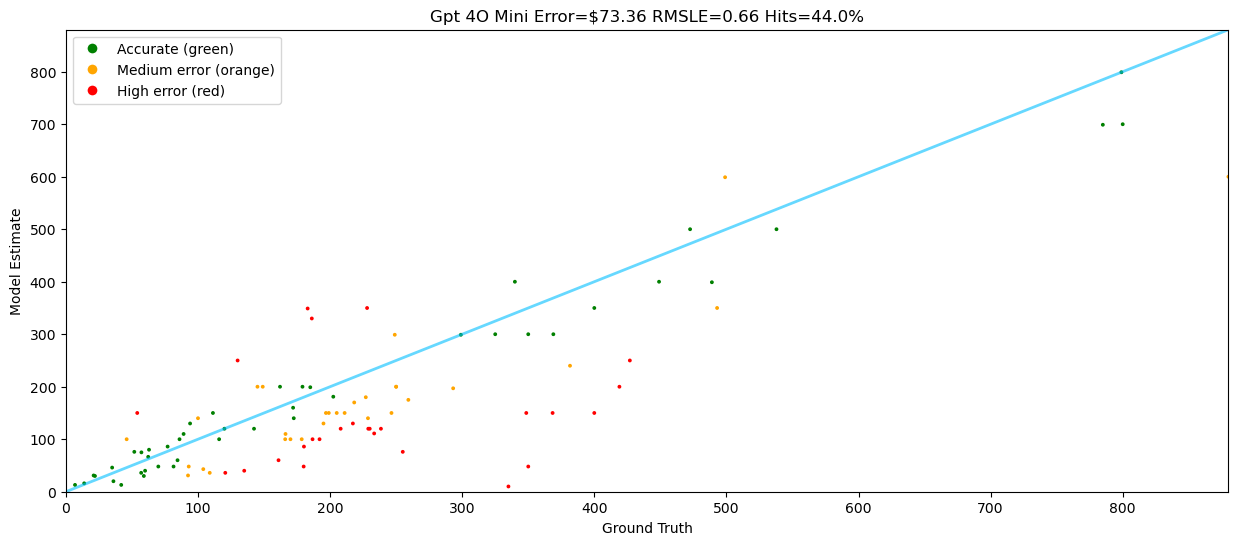

In [54]:
# Count tokens once before running
total_tokens = 0
for datapoint in train:
    messages = messages_for(datapoint)
    total_tokens += count_tokens(messages)
print(f"Total tokens: {total_tokens}")

def gpt_4o_mini(datapoint):
    messages = messages_for(datapoint)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages,
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

tester = Tester(gpt_4o_mini, test.select(range(100)))
tester.run()
results["gpt 4o mini"] = tester

## gpt 4o (the big guy 😎)

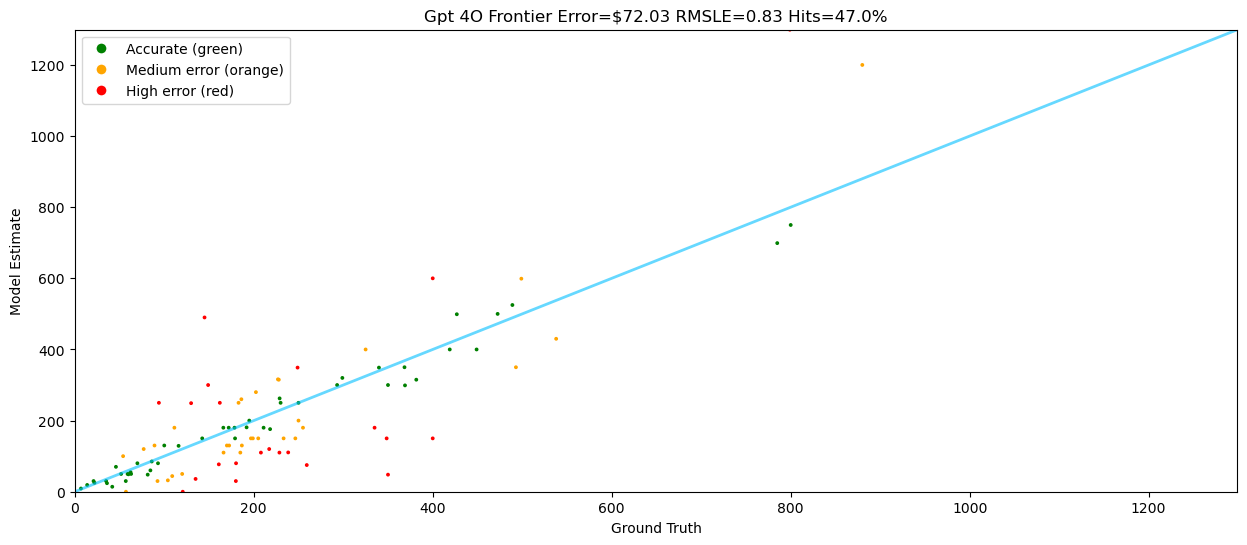

In [55]:
def gpt_4o_frontier(datapoint):
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=messages_for(datapoint),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

tester = Tester(gpt_4o_frontier, test.select(range(100)))
tester.run()
results["gpt 4o (the big guy)"] = tester

## claude 3.7 Sonnet

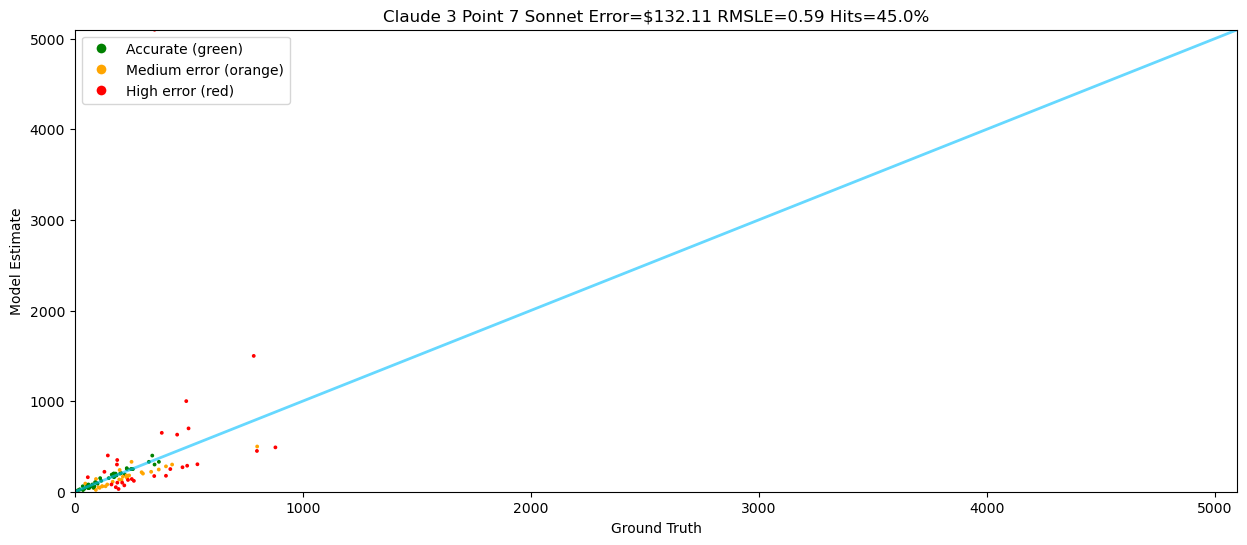

In [57]:
def claude_3_point_7_sonnet(datapoint):
    messages = messages_for(datapoint)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-7-sonnet-20250219",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

tester = Tester(claude_3_point_7_sonnet, test.select(range(100)))
tester.run()
results["claude 3.7 sonnet"] = tester

## groq model

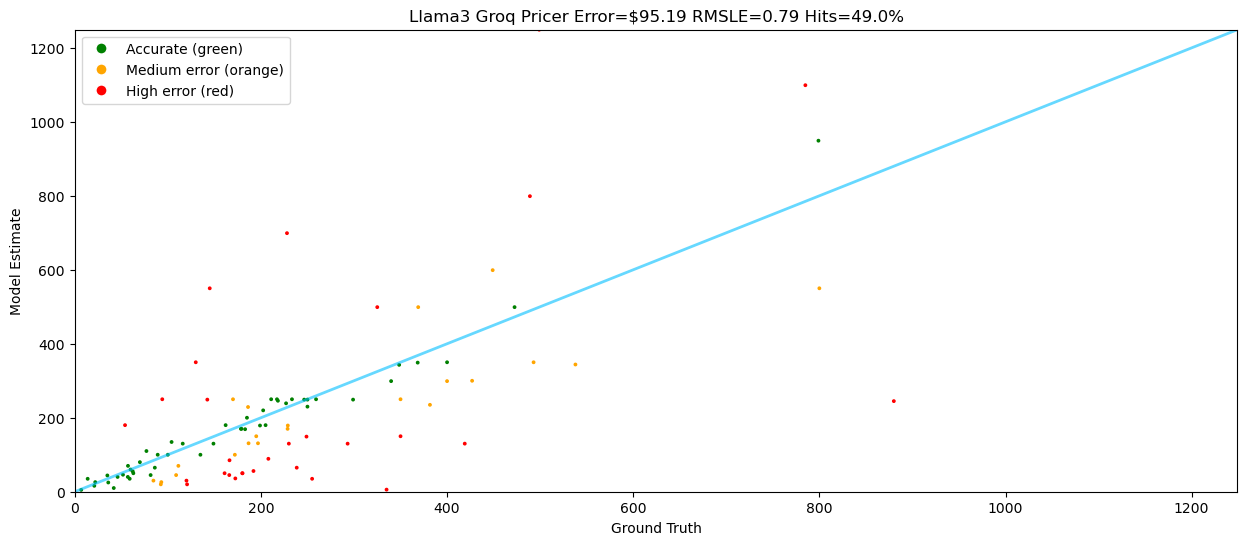

In [58]:
def llama3_groq_pricer(datapoint):
    response = groq.chat.completions.create(
        model="llama3-70b-8192",
        messages=messages_for(datapoint),
        max_tokens=5,
        seed=42
    )
    reply = response.choices[0].message.content
    return get_price(reply)

tester = Tester(llama3_groq_pricer, test.select(range(100)))
tester.run()
results["llama3-70b-8192"] = tester

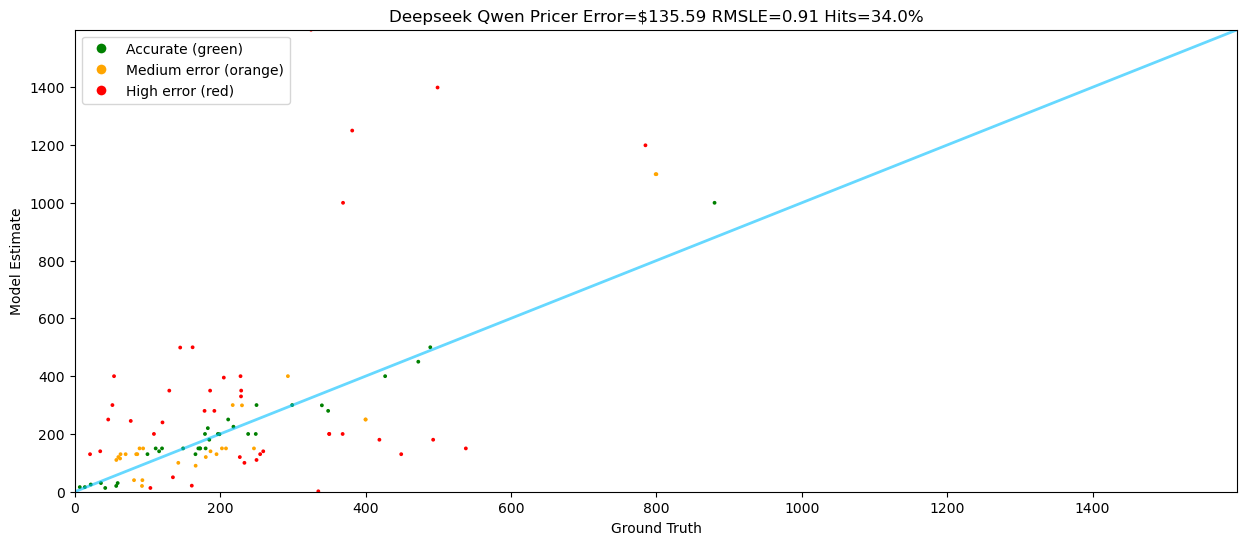

In [59]:
def deepseek_qwen_pricer(datapoint):
    response = groq.chat.completions.create(
        model="deepseek-r1-distill-qwen-32b",
        messages=messages_for(datapoint),
        max_tokens=5,
        seed=42
    )
    reply = response.choices[0].message.content
    return get_price(reply)

tester = Tester(deepseek_qwen_pricer, test.select(range(100)))
tester.run()
results["deepseek-qwen-32b"] = tester

# 🕵️ Human Judgement Baseline (Ed)

We include a human baseline from our instructor Ed, who manually estimated prices based on item descriptions (💪 thanks Ed for taking on this exhausting task!). This allows us to compare model performance against human intuition.

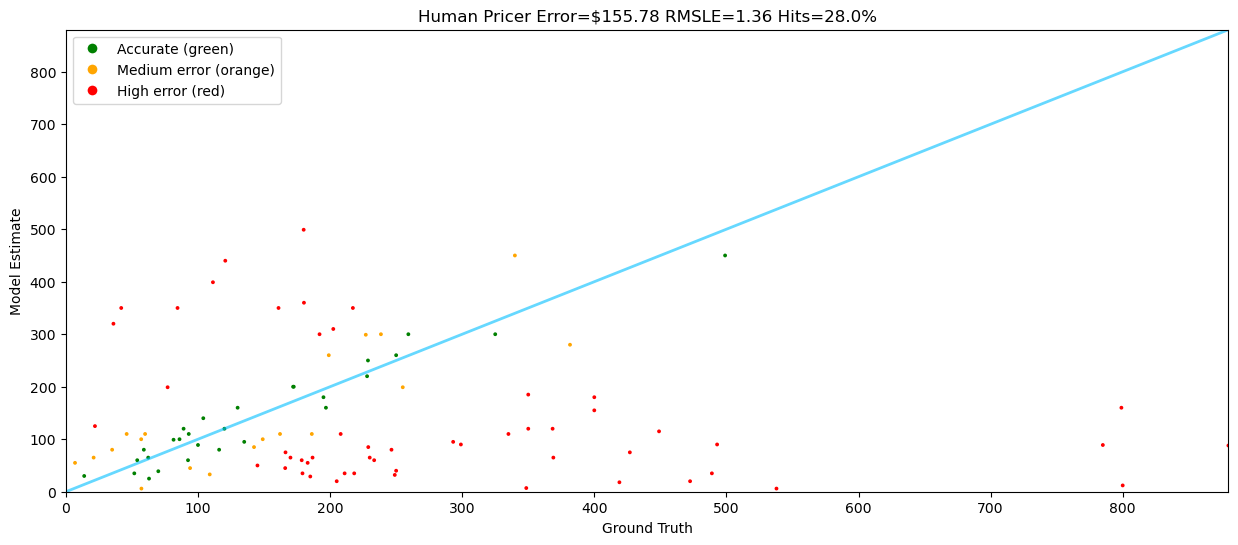

In [60]:
human_predictions = []

with open('data/human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

def human_pricer(datapoint):
    # `Tester` runs in order, so use the index from Tester itself
    idx = human_pricer.counter
    human_pricer.counter += 1
    return human_predictions[idx]

human_pricer.counter = 0  # initialize counter

tester = Tester(human_pricer, test.select(range(100)))
tester.run()
results["Human Predictions"] = tester


# 🥇 Benchmark Showdown: ML, LLMs, and Ed

In [61]:
def truncate(x, decimals=2):
    factor = 10 ** decimals
    return math.floor(x * factor) / factor

df_results = []

for model_name, tester in results.items():
    avg_error = truncate(sum(tester.errors) / tester.size)
    hit_percent = truncate(sum(1 for c in tester.colors if c == "green") / tester.size * 100)
    rmsle = truncate(math.sqrt(sum(tester.sles) / tester.size))

    df_results.append({
        "model": model_name,
        "avrg_error": avg_error,
        "rmsle": rmsle,
        "accuracy_%": hit_percent
    })

df_results = pd.DataFrame(df_results)
df_results = df_results.sort_values(by="avrg_error")

# Display with .2f formatting
print(df_results.to_string(index=False, float_format="{:.2f}".format))


               model  avrg_error  rmsle  accuracy_%
gpt 4o (the big guy)       72.02   0.83       47.00
         gpt 4o mini       73.35   0.66       44.00
   XGBoost Regressor       91.67   0.68       32.00
     llama3-70b-8192       95.19   0.79       49.00
     Bag of Words LR      112.75   0.95       26.00
          Linear SVR      115.45   0.93       24.00
         Word2Vec LR      123.17   0.84       25.00
   claude 3.7 sonnet      132.10   0.58       45.00
   deepseek-qwen-32b      135.59   0.91       34.00
   Human Predictions      155.78   1.35       28.00


🏁 **Now that we know who won** (as expected) — it’s time to move on.

Next: we'll fine-tune **two models** to see who can top the leaderboard:

- ⚡ **Frontier model:** GPT-4o Mini  
- 🦙 **Open-source model:** LLaMA 3 8B (quantized)

Who will beat all the others?

---

### 🔧 **Part 3: Fine-Tuning GPT-4o Mini**  
🤖 *Can a fine-tuned version of GPT-4o Mini beat its own zero-shot performance?*

Let’s find out.